# AnnCollection tutorial

This tutorial shows how to use AnnCollection class with one or multiple AnnData objects.

In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
import gdown

from anndata.experimental.multi_files import AnnCollection

from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA

import warnings
warnings.simplefilter(action="ignore", category=pd.core.common.SettingWithCopyWarning)

In [ ]:
# the data is from this scvi reproducibility notebook
# https://yoseflab.github.io/scvi-tools-reproducibility/scarches_totalvi_seurat_data/
gdown.download(url="https://drive.google.com/uc?id=1X5N9rOaIqiGxZRyr1fyZ6NpDPeATXoaC", 
               output="pbmc_seurat_v4.h5ad", quiet=False)
gdown.download(url="https://drive.google.com/uc?id=1JgaXNwNeoEqX7zJL-jJD3cfXDGurMrq9", 
               output="covid_cite.h5ad", quiet=False)

In [3]:
covid = sc.read('covid_cite.h5ad')
pbmc = sc.read('pbmc_seurat_v4.h5ad')

## AnnCollection initialization
AnnCollection is a wrapper class which allows to lazily concatenate and jointly subset AnnData objects along the obs axis.

You can initialize AnnCollection with one AnnData object.

In [4]:
dataset = AnnCollection([covid])

In [5]:
dataset

AnnCollection object with n_obs × n_vars = 57669 × 33538
  constructed from 1 AnnData objects
    view of obsm: 'pro_exp'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num'

`view of obsm` means that the wrapper object doesn't copy anything from .obsm of the underlying AnnData object. `obs` insted of `view of obs` means that the object copied .obs from the AnnData object. You can configure what is copied, please see the AnnCollection tutorial for deatils. The wrapper object (AnnCollection) never copies the full .X or .layers from the underlying AnnData object, all conversions happen when the AnnCollection object is subset.

But most importantly you can lazily join several AnnData objects without copying them. Set `join_vars='inner'` if you have different variables in the AnnData objects to create a joint index of the intersection of the variables

In [6]:
dataset = AnnCollection([covid, pbmc], join_vars='inner', join_obs=None, label='dataset')

`label='dataset'` means the AnnCollection object will have the column 'dataset' in its own .obs.

In [7]:
dataset

AnnCollection object with n_obs × n_vars = 219433 × 20729
  constructed from 2 AnnData objects
    view of obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT'
    own obs: 'dataset'

This object doesn’t copy data from AnnData objects, it uses joint index of observations and variables of the AnnData objects to allow joint subsetting. AnnCollection object has its own .obs and also view of inner join (you can select the type of join for .obs on initialization) of .obs in the passed AnnData objects. An AnnCollection object can also have its own .obsm if `join_obsm='inner'` is passed.

You can also initialize an AnnCollection object with backed AnnData objects

In [8]:
covid = sc.read('covid_cite.h5ad', backed='r')
pbmc = sc.read('pbmc_seurat_v4.h5ad', backed='r')

In [9]:
dataset = AnnCollection([covid, pbmc], join_vars='inner', join_obs=None, label='dataset')

In [10]:
dataset

AnnCollection object with n_obs × n_vars = 219433 × 20729
  constructed from 2 AnnData objects
    view of obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT'
    own obs: 'dataset'

You can subset AnnCollection to get observation related attributes of the lazily concatenated AnnData objects.

In [11]:
subset = dataset[56000:58000]

In [12]:
subset

AnnCollectionView object with n_obs × n_vars = 2000 × 20729
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT'

In [13]:
subset.X.shape

(2000, 20729)

In [14]:
subset.obs

View of obs with keys: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT'

In [15]:
subset.obs['orig.ident'][:2]

array(['SeuratProject', 'SeuratProject'], dtype=object)

Subsetting of an AnnCollection object returns AnnCollectionView. Only these subset objects have views of .obs, .obsm, .layers, .X from the passed AnnData objects. When an AnnCollection object is initialized with `join_obs=None` and `join_obsm=None`, the subset objects only give you access to the views of .obs, .obsm, .layers, .X from the passed AnnData objects. and not to .obs of AnnCollection. This is why you don't see dataset key among the .obs keys of the subset.

However, if you initialize an AnnCollection object with `join_obs='inner'` (for inner join of .obs in the passed AnnData objects) or `join_obs='outer'`, the AnnCollection with join and copy the result to its own .obs insted of creating a view. Then subset objects (AnnCollectionView) will give access to the .obs attribute of the AnnCollection object instead of the view of the lazily joined .obs of the underlying AnnData objects. When `join_obs` is not `None`, you have a copy of the concatenated .obs attributes in the AnnCollection object.

In [16]:
dataset = AnnCollection([covid, pbmc], join_vars='inner', join_obs='inner', label='dataset')

In [17]:
dataset

AnnCollection object with n_obs × n_vars = 219433 × 20729
  constructed from 2 AnnData objects
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset'

As you see, now the concatenated .obs attributes are copied to .obs of the AnnCollection object.

In [18]:
subset = dataset[56000:58000]

In [19]:
subset

AnnCollectionView object with n_obs × n_vars = 2000 × 20729
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset'

Note that now you can have access to the 'dataset'.obs column from subsets.

In [20]:
subset.obs['dataset'][:2]

GTTGTCCAGCAACAAT-1    0
GTTGTCCAGCGAGAAA-1    0
Name: dataset, dtype: category
Categories (2, object): ['0', '1']

Same can be done for .obsm, though only with inner join. `join_obsm='inner'` means do inner join and copy AnnCollection's own obsm, `join_obsm=None` means do inner join without copying and do not create obsm in an AnnCollection object, though AnncollectionView will still have access to the lazily inner joined .obsm attributes of the underlying AnnData objects.

In [21]:
# inner join of .obsm of the datasets covid and pbmc is empty
dataset = AnnCollection([covid, pbmc], join_vars='inner', join_obsm=None, label='dataset')

In [22]:
dataset.obsm is None

True

In [23]:
# inner join of .obsm of the datasets covid and pbmc is empty
dataset = AnnCollection([covid, pbmc], join_vars='inner', join_obsm='inner', label='dataset')

In [24]:
dataset.obsm is None

False

In [25]:
dataset.obsm

AxisArrays with keys: 

In [26]:
subset = dataset[56000:58000]

In [27]:
subset.obs

View of obs with keys: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset'

.obs of AnnCollectionView objects is a MapObsView object, but it can be converted to pandas DataFrame.

In [28]:
subset.obs.df

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,dataset
GTTGTCCAGCAACAAT-1,SeuratProject,3763.0,1353,268.0,35,0
GTTGTCCAGCGAGAAA-1,SeuratProject,5883.0,1931,515.0,32,0
GTTGTCCAGTGGTTCT-1,SeuratProject,1479.0,750,147.0,34,0
GTTGTCCCAAACGTGG-1,SeuratProject,8920.0,2588,788.0,37,0
GTTGTCCCAGCAGGAT-1,SeuratProject,3016.0,1261,257.0,34,0
...,...,...,...,...,...,...
L1_AACGTCACAACTCATG,P1_0,4571.0,1838,4667.0,218,1
L1_AACGTCACAATCCTAG,P4_7,4351.0,1234,6718.0,213,1
L1_AACGTCACAGCTCGGT,P1_0,3922.0,1602,4267.0,219,1
L1_AACGTCACAGGAATAT,P3_7,6033.0,1395,5277.0,213,1


Yo can also create a converter with a function or a Mapping of functions which will be applied to the values of attributes (`.obs`, `.obsm`, `.layers`, `.X`) or to specific keys of these attributes in the subset object. Specify an attribute and a key (if needed) as keys of the passed Mapping and a function to be applied as a value (see also the AnnLoader tutorial)

For example, now .X is a sparse matrix.

In [29]:
subset.X

<2000x20729 sparse matrix of type '<class 'numpy.float32'>'
	with 3935425 stored elements in Compressed Sparse Row format>

You can set up a converter to densify it on the fly.

In [30]:
convert = {'X': lambda a: a.toarray()}

dataset.convert = convert # or during the initialization AnnCollection(..., convert=convert)

In [31]:
dataset[56000:58000].X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Use with AnnLoader

You can directly pass Anncollection to AnnLoader (see also the AnnLoader tutorial).

In [32]:
from anndata.experimental.pytorch import AnnLoader

In [33]:
dataloader = AnnLoader(dataset, batch_size=128)

By default AnnLoader adds its own converter on top of converters in AnnCollection. It densifies sparse arrays, converts dense numeric arrays to pytorch tensors, transfers to the default cuda device (if `use_cuda=True`), does memory pinning (if `pin_memory=True`). If you pass an AnnCollection object with prespecified converters, the default converter won't overwrite these converters but will be applied on top of them.

In [34]:
dataloader.dataset[:2].X.dtype

torch.float32

You can also pass an AnncollectionView object (subset object) to AnnLoader. This can be useful when you want to do a train test split without creating copies of your huge AnnData objects.

In [35]:
train, test = train_test_split(dataset)

In [36]:
train

AnnCollectionView object with n_obs × n_vars = 164574 × 20729
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset'

In [37]:
test

AnnCollectionView object with n_obs × n_vars = 54859 × 20729
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'dataset'

In [38]:
dataloader = AnnLoader(train, batch_size=128)

In [39]:
dataloader.dataset[:2].X.dtype

torch.float32

## Example: use AnnCollection for iterative PCA

This example shows how to get joint PCA of both AnnData objects without in-memory concatenation.

In [57]:
covid = sc.read('covid_cite.h5ad')
pbmc = sc.read('pbmc_seurat_v4.h5ad')

In [37]:
sc.pp.normalize_total(covid)
sc.pp.log1p(covid)

sc.pp.normalize_total(pbmc)
sc.pp.log1p(pbmc)

Setting `join_obsm='inner'` to have a separate .obsm in AnnCollection object.

In [38]:
dataset = AnnCollection(dict(covid=covid, pbmc=pbmc), convert=dict(X=lambda a: a.toarray()),
                        join_vars='inner', join_obs='outer', join_obsm='inner', label='dataset')

In [39]:
dataset.obsm['X_pca'] = np.empty((dataset.shape[0], 50), dtype='float64') # for future pca projections

In [40]:
dataset

AnnCollection object with n_obs × n_vars = 219433 × 20729
  constructed from 2 AnnData objects
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'dataset'
    obsm: 'X_pca'

As `join_obs='outer'`, the subsets (AnnCollectionView objects) will point to the .obs attribute of the dataset.

In [41]:
dataset[:2].obs

View of obs with keys: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'dataset'

Use the 'orig.ident' column for joint batch information.

In [42]:
dataset.obs['orig.ident'].loc[covid.obs_names] = covid.obs['set']

In [43]:
ipca = IncrementalPCA(n_components=50)

Use the built-in iterator over the AnnCollection object to get bacthes of data with 6000 observations each and fit partial PCA.

In [44]:
for batch, idx in dataset.iterate_axis(6000):
    ipca.partial_fit(batch.X)

Use the iterator to transform the normalized counts.

In [45]:
for batch, idx in dataset.iterate_axis(6000):
    dataset.obsm['X_pca'][idx] = ipca.transform(batch.X)

You can then convert an AnnCollecion object to an AnnData object. The AnnData object won't have .X or .layers, only .obs and .obsm. In order to get also .X and .layers, you need to call to_adata() for an AnnCollectionView object (subset of an AnnCollection object).

In [46]:
adata = dataset.to_adata()

In [47]:
adata

AnnData object with n_obs × n_vars = 219433 × 20729
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'dataset'
    obsm: 'X_pca'

In [48]:
adata.X is None

True

In [49]:
sc.pp.neighbors(adata)

In [50]:
sc.tl.umap(adata)

... storing 'orig.ident' as categorical
... storing 'RNA_snn_res.0.4' as categorical
... storing 'seurat_clusters' as categorical
... storing 'set' as categorical
... storing 'Resp' as categorical
... storing 'disease' as categorical
... storing 'subj_code' as categorical
... storing 'covidpt_orhealth' as categorical
... storing 'bust_21' as categorical
... storing 'og_clust' as categorical
... storing 'severmod_other' as categorical
... storing 'og_clusts' as categorical
... storing 'final_clust' as categorical
... storing 'final_clust_v2' as categorical
... storing 'new_pt_id' as categorical
... storing 'Resp_og' as categorical
... storing 'final_clust_withnum' as categorical
... storing 'final_clust_review' as categorical
... storing 'Gender' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'time' as categorical
... storing 'celltype.l1' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
...

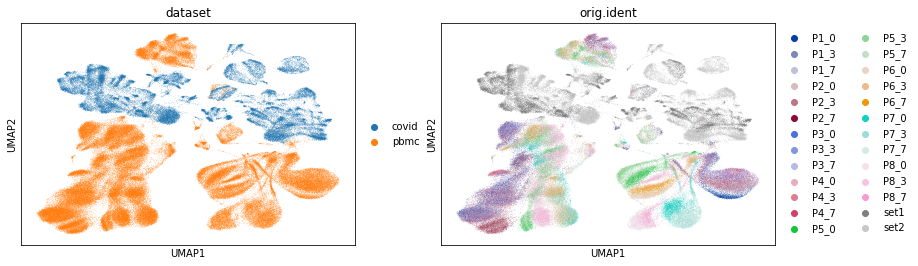

In [51]:
sc.pl.umap(adata, color=['dataset', 'orig.ident'])

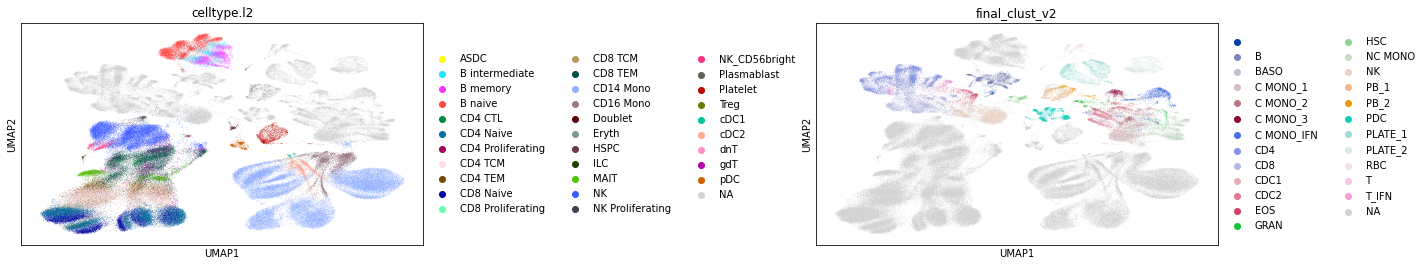

In [52]:
sc.pl.umap(adata, color=['celltype.l2', 'final_clust_v2'], wspace=0.8)